In [1]:
#########################################################
# Visual Geometry HOMEWORK - 1 
# Lecturer : Jongwon Choi (GSAIM, Chung-Ang University)
# Date : 2020.09.28
#########################################################

In [2]:
#################  DONT TOUCH  ########################
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#################  DONT TOUCH  ########################

In [3]:
#################  DONT TOUCH  ########################
## Homography warping function
def myApplyH(im, H):
  import cv2
  return cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
#################  DONT TOUCH  ########################

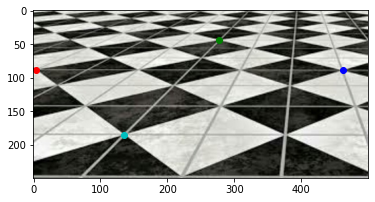

In [4]:
#################  DONT TOUCH  ########################
## Image Read & Point Picking (Square Region)
img = mpimg.imread('./floor.png')

pts = [[4,88], [277, 44], [462,89], [135,185]]

plt.imshow(img)
for i, clr in enumerate(['r', 'g', 'b', 'c']):
  plt.scatter(pts[i][0],pts[i][1],color=clr)
#################  DONT TOUCH  ########################

In [5]:
## Coordinates Transformation

# to homogeneous
def homoCoord(inhomo):
    if not type(inhomo) == np.array:
      inhomo = np.array(inhomo)

    one = np.ones((1, inhomo.shape[0]))
    homo = np.concatenate((inhomo.T, one), axis=0)
    return homo


# to inhomogeneous
def inhomoCoord(homo):
    inhomo = homo[0:2, :].T
    return inhomo

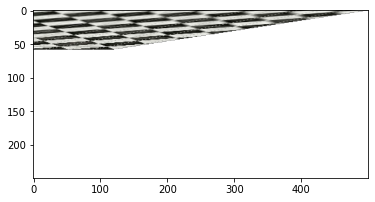

In [6]:
## Problem 1. Image Rectification (USE ONLY NUMPY LIBRARY)
# H_rec = np.identity(3)
###############################################################

def H_p(p):
  H_rec = np.identity(3)

  ## Parallel lines l1&l2 intersect v1, parallel lines m1//m2 intersect at v2
  # p1 X p2 = l --> p1, p2를 지나는 직선 l
  l1 = np.cross(p.T[0], p.T[3])
  l2 = np.cross(p.T[1], p.T[2])
  m1 = np.cross(p.T[0], p.T[1])
  m2 = np.cross(p.T[3], p.T[2])

  # Point at infinity
  # l1 X l2 = v --> 두 직선 l1, l2가 교차하는 지점 v
  v1 = np.cross(l1, l2)
  v2 = np.cross(m1, m2)

  # Line at infinity
  vL = np.cross(v1, v2)
  # vL = vL / np.linalg.norm(vL)
  vL = vL / vL[2]

  H_rec[2:,] = vL.T

  return H_rec


p = homoCoord(pts)
H_rec = H_p(p)

###############################################################

rectified_img = myApplyH(img, H_rec)
plt.imshow(rectified_img)

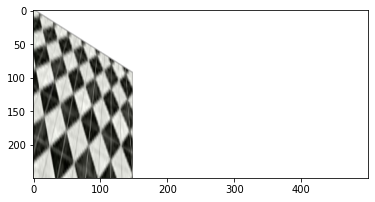

In [7]:
## Problem 2. Image Affine (Only Orthogonal) (USE ONLY NUMPY LIBRARY. hint: np.linalg.svd, np.linalg.cholesky, np.linalg.inv are necessary.)
# H_aff = np.identity(3)
###############################################################

"""
1. affine rectification이 된 경우 (<-- This case)
   직선 세트 2개 이용하여 C'* 구한다.
      H_a = [K   0]
            [0T  1]

      C'* = [KKT 0]
            [0T  0]
  
   - find symmetric matrix S := KKT
   - find K via Cholesky decomposition of S


2. affine rectification이 되지 않은 경우
   직선 세트 5개 이용하여, C'* 구한다.

      C'* = [KKT  KTv]
            [vTK  vTv]
"""

def H_a(p):
  H_aff = np.identity(3)
  
  ## orthogonal lines l1 ㅗ m1, l2 ㅗ m2 
  l1 = np.cross(p.T[0], p.T[1])
  m1 = np.cross(p.T[1], p.T[2])
  l2 = np.cross(p.T[0], p.T[2])
  m2 = np.cross(p.T[1], p.T[3])

  # # dependency case
  # l1 = np.cross(p.T[0], p.T[3])
  # l2 = np.cross(p.T[1], p.T[2])
  # m1 = np.cross(p.T[0], p.T[1])
  # m2 = np.cross(p.T[3], p.T[2])

  # As = 0, s != 0 --> SVD, s = last column of V
  A = np.array([[l1[0]*m1[0], l1[0]*m1[1] + l1[1]*m1[0], l1[1]*m1[1]],
                [l2[0]*m2[0], l2[0]*m2[1] + l2[1]*m2[0], l2[1]*m2[1]]])

  # rank(A) = 2 --> no dependency  
  rank = np.linalg.matrix_rank(A)
  
  if rank == 2:
    U, DD, VT = np.linalg.svd(A)
    s = VT[-1,:] / VT[-1,-1]
    S = np.array([[s[0], s[1]], [s[1], s[2]]])

    # Obtain K using Cholesky factorization:
    K = np.linalg.cholesky(S)

    # det(K) = 1
    K = K / np.sqrt(np.linalg.det(K))

    # inverse K
    K = np.linalg.inv(K)

    H_aff[:2,:2] = K

    return H_aff
  
  else:
    raise Exception('pairs of orthogonal lines are dependency')

# affine rectified points
p_rec = np.matmul(H_rec, p)

H_aff = H_a(p_rec)

###############################################################

affine_img = myApplyH(img, H_aff)
plt.imshow(affine_img)


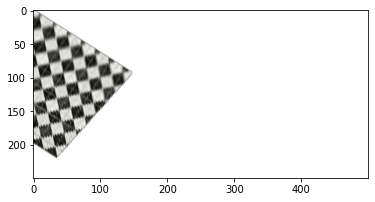

In [8]:
###############################################################
affine_img = myApplyH(rectified_img, H_aff)
plt.imshow(affine_img)

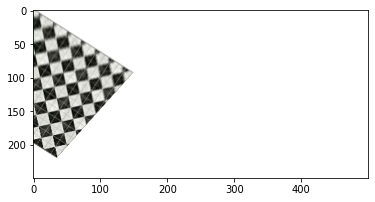

In [9]:
## Problem 3. Image Projective (Both of Rectification & Orthogonal) (USE ONLY NUMPY LIBRARY. Hint. We can solve this within just one line by using the above results)
# H_dual = np.identity(3)
###############################################################

def H_final(Ha, Hp):
  H_dual = np.identity(3)
  H_dual = np.matmul(Ha, Hp)
  return H_dual


H_dual = H_final(H_aff, H_rec)

###############################################################

final_img = myApplyH(img, H_dual)
plt.imshow(final_img)

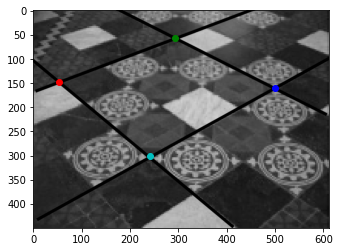

In [10]:
## Problem 4. Test
import cv2

img2 = mpimg.imread('./floor2.png', -1)

pts2 = [[53, 148], [293, 57], [500, 160], [241, 300]]

plt.imshow(img2)
for i, clr in enumerate(['r', 'g', 'b', 'c']):
  plt.scatter(pts2[i][0],pts2[i][1],color=clr)

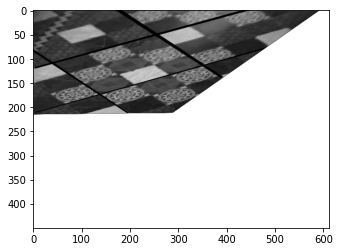

In [11]:
pts2 = homoCoord(pts2)
H_rec2 = H_p(pts2)

rectified_img2 = myApplyH(img2, H_rec2)
plt.imshow(rectified_img2)

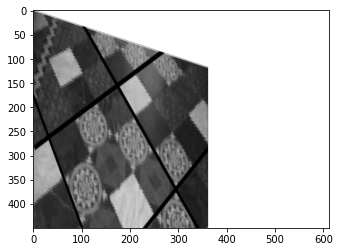

In [12]:
ppts2 = np.matmul(H_rec2, pts2)
H_aff2 = H_a(ppts2)

affine_img2 = myApplyH(img2, H_aff2)
plt.imshow(affine_img2)

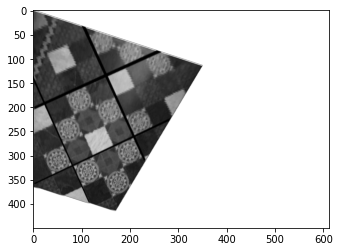

In [13]:
affine_img2 = myApplyH(rectified_img2, H_aff2)
plt.imshow(affine_img2)

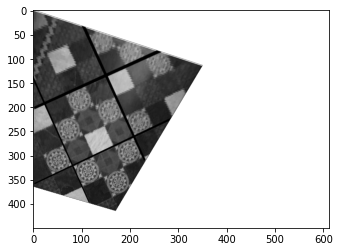

In [14]:
H = H_final(H_aff2, H_rec2)

final_img2 = myApplyH(img2, H)
plt.imshow(final_img2)